# Instrumentacion y control: Practica 1 - Placa de audio #

## Introducción ## 
En este notebook vamos a implementar y registrar mediciones utilizando una placa de sonido. 

Para eso utilizamos el paquete soundDevice y desarrollamos codigo propio de manera de adaptar las funcionalidades que ofrece dicho paquete. El objetivo es tener montado sobre las funcionalidades de python y soundDevice una API que permita usar en forma rapida e intuitiva la placa de sonido para interactuar con dispotivos electronicos, usando el speaker como salida y el mic como entrada.

## Funcionalidades buscadas ##

- Generar señales periodicas tipicas (sinusoidal, triangular, cuadrada, etc)
- Registrar respuestas del sistema conectado frente a estimulos.
- Testear y autocaracterizar el sistema de la placa de sonido (ya que puede cambiar de computadora en computadora) 
- Conocer desfazaje entre estimulo enviado y respuesta detectada. 

## Materiales y Diseño experimental basico ## 

Para hacer funcionar el sistema se necesita una computadora o dispositivo que cuente con una salida de audio y una entrada fisicamente independiente de microfono. Ademas se necesita dos conectores Jack Mini Plug de 3.5mm (o la que corresponda al hardware donde se ejecute el codigo) stereo que terminen en cables sueltos. En nuestro caso para realizar todas las prueba experimentales conectamos dicho terminales a un protoboard. 

![setup inicial](Files/Imagenes/Setup1.jpeg)
![setup inicial](Files/Imagenes/Setup2.jpeg)

## Desarrollo de sofware ##

El codigo desarrollado esta incluido en el archivo AudioControl.py en forma de funciones de manera tal que se pueda importar el archivo y utilizarlas en forma directa. 
Describimos brevemente las funciones utiles:



# Mediciones y testeos #

El primer test a realizar es que el programa tenga acceso a la placa. Para eso debemos conectar el parlante usual a la salida de audio y ejecutar:

In [2]:
import AudioControl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%load_ext autoreload

In [2]:
# testeamos la salida conectado a parlantes

In [3]:
AudioControl.testOutput()

Tendría que haber escuchado 1 segundo de audio en cada canal


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:59<00:00,  1.14s/it]


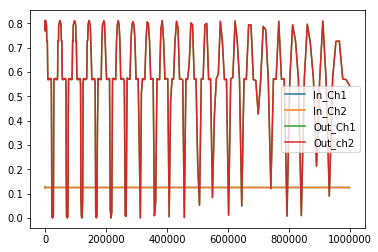

In [2]:
# Hacemos un barrido en frecuencias. Para chequear que todo funcione bien, primero lo hacemos con un cable comprado que tiene dos miniplug donde conectamos una la salida y otro a la entrada. 
Frecs, In, Out = AudioControl.RtaFrecuencia()

In [6]:
# Almacenamos los datos
import numpy as np
np.savetxt ('./Resultados/RtaFrecCableBuenoFrecs.txt',Frecs,delimiter=',')
np.savetxt ('./Resultados/RtaFrecCableBuenoIn.txt',In,delimiter=',')
np.savetxt ('./Resultados/RtaFrecCableBuenoOut.txt',Out,delimiter=',')


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:52<00:00,  1.12s/it]


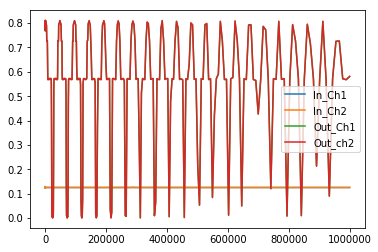

In [7]:
# Repetimos la medicion con los cables y el protoboard armados y conectados (esperamos la misma respuesta que antes salvo que el protoboarod o los cables traigan complicaciones.)
# NOTA: Uno de los plug tiene mucho problema para conectar bien, tuvimos que probar mucho (haciendo un play rec sencillo) hasta encontrar la posicion en que hace contacto a traves de los dos canales. 
# Suponemos que es una cuestion de la forma del macho o hembra que no acoplan bien. 
FrecsBis, InBis, OutBis = AudioControl.RtaFrecuencia()

In [8]:
np.savetxt ('./Resultados/RtaFrecCablePropioFrecs.txt',FrecsBis,delimiter=',')
np.savetxt ('./Resultados/RtaFrecCablePropioIn.txt',InBis,delimiter=',')
np.savetxt ('./Resultados/RtaFrecCablePropioOut.txt',OutBis,delimiter=',')

In [2]:
# Nota hicimos algunos cambios en el codigo, ahora el output del scan de frecuencias da una sola variable y ademas hay que indicar si se quiere que sea en los dos canales o no. Y grafica en escala log

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:09:00<00:00,  4.14s/it]


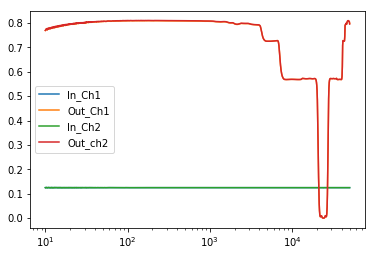

In [3]:
# Volvemos a ejecutar el analisis pero en un rango acotado de frecuencias que son las mas usuales. 
RtaFrecProtoboard = AudioControl.RtaFrecuencia(frec_max=50000,stereo=True)

In [6]:
np.savetxt ('./Resultados/RtaFrecCableFrecuenciasBajas.txt',RtaFrecProtoboard,delimiter=',')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:27<00:00,  3.26s/it]


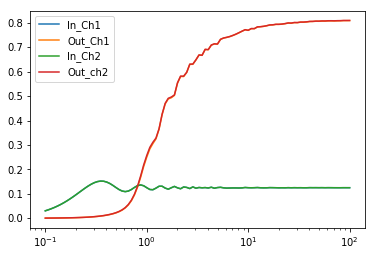

In [3]:
# Volvemos a ejecutar el analisis pero en un rango acotado de frecuencias que son las mas usuales. 
RtaFrecProtoboard = AudioControl.RtaFrecuencia(frec_min=0.1,frec_max=100,stereo=True, pasos=100)

In [4]:
np.savetxt ('./Resultados/RtaFrecCableFrecuenciasMuyBajas.txt',RtaFrecProtoboard,delimiter=',')

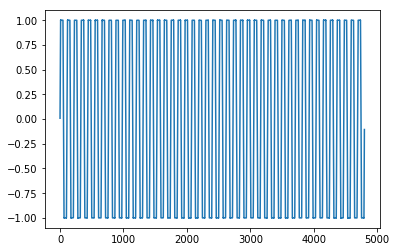

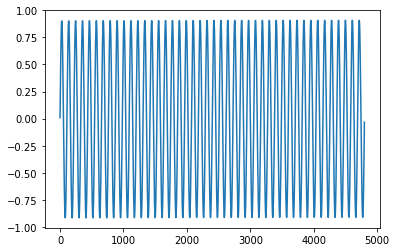

In [7]:
# Ahora vamos a caracterizar el slewrate. Para eso lo ideal seria tener una funcion armado, pero por problemas de tiempo y prioridades todavia no esta hecha. 
# En su lugar vamos a hacer un playrec de una señal cuadrada a frecuencia razonable y observar cuanto tarda en hacer el cambio de voltaje. 
# Como es fundamental hacer el salto de volumnen lo mayor posible, primero vamos a verificar el nivel de volumen y de saturacion de la configuracion de sonido con una señal sinusoidal.
void = AudioControl.playrec_sync(AudioControl.Onda(440,long=0.1),plot=True) # Vemos que satura, esto tiene que ver con el nivel de volumen del la PC
void = AudioControl.playrec_sync(AudioControl.Onda(440,long=0.1,amp=0.2),plot=True)

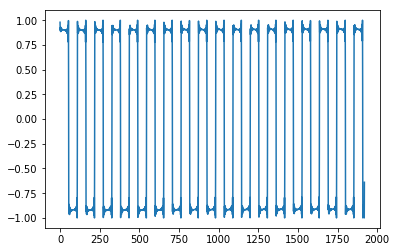

In [7]:
cuadrada = AudioControl.playrec_sync(AudioControl.square(440,long=0.04,amp=0.2),plot=True) # Menos de 0.04 segundos ya el codigo genera un error porque no puede agregar los dos trigguers.

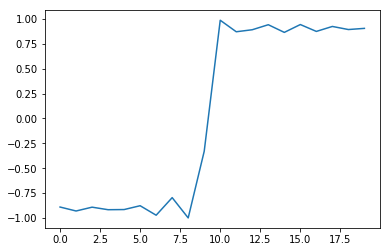

In [8]:
# Vamos a reestructurar los datos para que se vea mejor
cuadrada = cuadrada[100:120]
plt.plot(cuadrada) # Como se puede ver tarda 2 samples en hacer un delta de 2 (en escala arbitraria a determinar). El slewrate es 1 en la escala de señal x frame


### Determinar escala ###

Para determinar la escala vamos a recurir a un puerto USB como fuente de alimentacion y a cinco resistencias de 100 ohms en serie. Segun wikipedia el maximo de corriente del estandar usb 2.0 es 500 mA por lo que al tener 5V la carga minima que se le puede poner son 10ohms. Con una resistencia de 100ohms nos aseguramos estar largamente por debajo de dicha potencia y al poner 5 en serie tenemos una escala de 1V para usar de referencia.

## No funciono! ##

Luego de googlear resulto que 1V es mucho para una entrada de mic, por lo que pusimos mas restencias de manera de poder educir mas el voltaje. De todos modos, probado con 5Mv o con 60mV o con mas resulto que siempre vemos la misma señal de respuesta que no depende de la señal de entrada. 

Esta es la rta del sistema en una medicion de 10seg donde pulsamos y soltamos el pulsador.

![Rta5mV](Files/Imagenes/Pulsador5mV.png)

En cambio si se pulsa y suelta contra una refrencia de 6mV se ve algo muy similar. 

![Rta60mV](Files/Imagenes/Pulsador60mV.png)

Asumimos que el problema es que ademas de algun tipo de pasaaltos la entrada del mic tiene un circuito activo que responde a los picos de forma siempre similar sin importar mucho el valor del pico. 

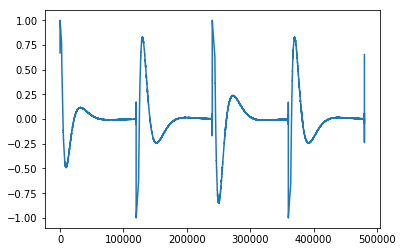

In [9]:
# Para comparar vamos a hacer las siguientes mediciones con una cuadrada. aca ademas de las limitaciones del receptor esta incluida la del emisor
data = AudioControl.playrec_sync(AudioControl.square(0.2,long=10), plot=True)

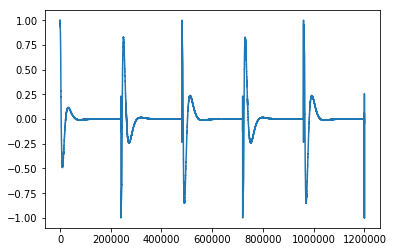

In [10]:
data = AudioControl.playrec_sync(AudioControl.square(0.1,long=25), plot=True)

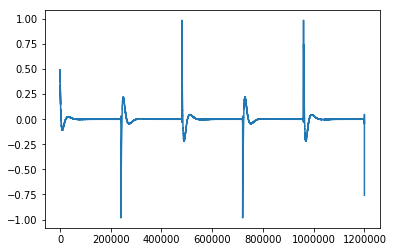

In [11]:
data = AudioControl.playrec_sync(AudioControl.square(0.1,long=25,amp=0.1), plot=True)